In [ ]:
# 1. Check if the DPS are similar. (Mostly the one less than 300s is a bit different than the rest)
# 2. Find the lowest mth with max clusters identified by modifying the Gaussian filter sigma for background by verifying the cluster centre in "Corrosion rate final analysis" with the image.
# 3. Run single DP in "all DP analysis final" to get the x_arr, y_arr. 
# 4. Filter the ones corresponding to the 3 rings of Inconel by changing epsilon.
# 5. Check if the clusters are repeated and then modify DBSCAN params accordingly. verify with image.
# 5. Put those in "Corrosion rate final analysis" and run for all files
# 6. Check the fitting values and correct initial guess and filtering condition. Write down the counts.
# 7. If cant fit finally add values to intensity and increment counts manually
# 8. To correct for total Intensity: Find the total intensity and then subtract the (totint per pixel*# of pixels(i.e counts)) from sum intensity.

In [ ]:
# Import the required image processing, scientific computing and visualization libraries 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.optimize as opt
import pandas as pd
from skued import diffread, baseline_dwt
from collections import Counter
from scipy.ndimage import gaussian_filter
from sklearn.cluster import DBSCAN
import math as mt


In [ ]:
# Read the image file onto a 2D matrix with raw intensity values
def load_non_unit(fname):
    img = Image.open(fname).convert('F')
    img1 = img.crop((0.,0.,1750,1400))

    return np.reshape(np.array(img1.getdata()), img1.size[::-1])

# Read the image file onto a 2D matrix with normalized intensity values    
def loadImage(fname):
    img = Image.open(fname).convert('F')
    img1 = img.crop((0.,0.,1750,1400))

    return np.reshape(np.array(img1.getdata()), img1.size[::-1])/np.max(img1)

# Returns the sum of intensities of an image file
def sumIntensity(fname):
    img = Image.open(fname).convert('F')
    img1 = img.crop((0.,0.,1750,1400))
    return np.sum(img1)

def sumIntensityfiltered(fname):
    M = loadImage(fname)
    Msmooth = (gaussian_filter(M, sigma=50., mode='reflect'))
    return np.sum(Msmooth)

def mapColor(Ii, Imin, Imax, gamma):
    Iratio = (Ii - Imin)/(Imax - Imin)
    Iclamped = np.minimum(np.maximum(Iratio, 0.), 1.)
    return Iclamped ** gamma

In [ ]:
#Clustering Algorithm on edited image. The input is a 2D matrix of normalized intensities. 
#Mthresh digitizes input pixel. 
#The module clusters points with intensity = 1.
#Every pixel gets a label, pixel belonging to a cluster gets the same label. 
#All labels stored in "labels" list
def cluster_centers(Mthresh):
    no_of_rows, no_of_cols = Mthresh.shape
    Msmooth_to_cluster2 = []
    for i in np.arange(no_of_rows):
        for j in np.arange(no_of_cols):
            if(Mthresh[i][j] == 1):
                Msmooth_to_cluster2.append([i,j])

    no_of_rows, no_of_cols = np.array(Msmooth_to_cluster2).shape           
    dbs = DBSCAN(eps=5, min_samples=18)
    dbs.fit(Msmooth_to_cluster2)
    labels = dbs.labels_
    labels_unique = np.unique(labels)
    nm = max(list(labels),key=list(labels).count)

# All cluster centres coordinates are stored in x_arr and y_arr
    x_arr = []
    y_arr = []

    for i in labels_unique:
        sum_x = 0.0
        sum_y = 0.0
        count = 0.0
        #identifying pixels belonging to cluster i
        for j in range(len(labels)):
            if (i==labels[j]):
                sum_x=sum_x+Msmooth_to_cluster2[j][0]
                sum_y=sum_y+Msmooth_to_cluster2[j][1]
                count=count+1
        #to find Centre spot co-ordinates of the DP
        if(i == nm):
            center_cluster_x = int(sum_x/count)
            center_cluster_y = int(sum_y/count)

        x_arr.append(int(sum_x/count))
        y_arr.append(int(sum_y/count))  
    
    
    print (center_cluster_x, center_cluster_y)
    return center_cluster_x, center_cluster_y, x_arr, y_arr

In [ ]:
import scipy.optimize as opt
import pandas as pd
from scipy import ndimage, misc
import math

#Crops and saves in an image file a 16 cross 16 region around each cluster center
def do_cropping(x_ring_arr, y_ring_arr,temp_file_name):
    
    for i in range(len(x_ring_arr)):
        file_name = "cropped_images/x"+str(y_ring_arr[i])+"_y"+str(x_ring_arr[i])+".tif"
        center_x = y_ring_arr[i]
        center_y = x_ring_arr[i]
        half_width = 8
        half_height = 8

        imageObject = Image.open(temp_file_name)

        cropped = imageObject.crop((center_x - half_width,
                                    center_y - half_height, 
                                    center_x + half_width,
                                    center_y + half_height,
                                    ))
        cropped.save(file_name)
        
# GAUSSIAN INTENSITY FIT    
def intensity_fit(pos, xo, yo, bg, A):
    x = pos[0]
    y = pos[1]
    sigma = 6.0
    intensity = A*np.exp(0.5*-((x-xo)/sigma)**2  
                      -((y-yo)/sigma)**2) + bg #np.exp(bg)
    
    return intensity.ravel()

# For each Cropped image, fit a gaussian function  
def gaussian_fit(file_name, x_pixel,y_pixel):    
    image = Image.open(file_name).convert('F')
    intensity_data = np.array(image)
    
    intensity_filter_out = intensity_data

    np.shape(intensity_filter_out)
    no_of_rows = len(intensity_filter_out)
    x = np.arange(0,no_of_rows,1)
    y = np.arange(0,no_of_rows,1)
    sigma = 6.0

    pos = np.meshgrid(x,y)
    
    #initial guess:
    xo = 8
    yo = 8
    bg = 9000
    A = 2000
    epsilon_pixels = 2
    epsilon_arr = np.arange(-epsilon_pixels,epsilon_pixels+1,1)
    
    initial_guess = np.array((xo, yo, bg, A ))
    
    try:
        popt, pcov = opt.curve_fit(intensity_fit, pos, intensity_filter_out.ravel(), initial_guess, maxfev=20000)
        stdevs = np.sqrt(np.diag(pcov))
        if(popt[0]<=1 or popt[0]>=16 or popt[1]<=0 or popt[1]>=16 or popt[3]<100 or stdevs[0]>1.5 or stdevs[1]>1.5):
            return 0
        else:    
            plt.figure(dpi=1200)
            plt.rcParams['font.size'] = 14
            plt.rcParams['font.family'] = 'Times New Roman'
            plt.rcParams['xtick.direction'] = 'in'
            plt.rcParams['ytick.direction'] = 'in'

            fig, ax = plt.subplots(1, 1)
            ax.imshow(intensity_filter_out, cmap='magma', origin='lower')
            ticks = np.linspace(0,15,4)
            ax.set_yticks(ticks)
            ax.contour(x, y, intensity_fit(pos, *popt).reshape(no_of_rows, no_of_rows), 8, colors='w')
            plt.xlabel('Pixel #',fontsize=17)
            plt.ylabel('Pixel #',fontsize=17) 
            plt.savefig('plots/contour_intensity_x'+str(y_pixel)+'_y'+str(x_pixel)+".png", dpi=1000) 
 # popt[3]  is Intensity(A) only (excluding background (bg)           
            return  popt[2], popt[3]  
                 
    except RuntimeError:
        return bg, 0

In [ ]:
# Finds the histogram of d-spacings of cluster centers
def get_dspacing(x_arr,y_arr, center_cluster_x, center_cluster_y,th, no_of_bins,intensities):
    # Computes radii of each Cluster centre
    radius = np.sqrt(((np.array(x_arr) - center_cluster_x)**2)+((np.array(y_arr) - center_cluster_y)**2))
    idx = radius>0     
    radius = radius[idx]
    # All cluster centres with 0 radius are removed; x_arr and y_arr updated
    x_arr = np.array(x_arr)[idx]
    y_arr = np.array(y_arr)[idx]
    # Gaussian fitted Intensities
    intensities = np.array(intensities)[idx]
    
    
    d_spacing = 1424/(2*np.array(radius))
    # Histogram of d-spacings (y axis is total number of points in one bin)
    count_hist, d_bin_edges = np.histogram(d_spacing, bins= no_of_bins, range = (0,6))
    # Histogram of d-spacings weighted by Intensity,
    # (y axis is total sum Intensity in one bin) add all intenties of cluster centres in the same d spacing bin
    # approx one ring of DP
    intensity_hist, d_bin_edges = np.histogram(d_spacing, bins= no_of_bins, range = (0,6), weights=intensities)
    d_bin_centers = d_bin_edges[:-1] + np.diff(d_bin_edges)/2
    intensity_hist[count_hist < th] = 0
    count_hist[count_hist < th] = 0
    count_hist[intensity_hist <= 0] = 0

    
    return count_hist,intensity_hist, d_bin_edges, d_bin_centers

In [ ]:
def find_x_ring_y_ring(x_arr,y_arr,center_cluster_x, center_cluster_y):
 
    # Inconel
    r1 = 344.0
    r2 = 395.5
    r3 = 560.6
    r4 = 659.3
    # MgO
    # r1 = 585
    # r3 = 965
    #r = [r2, r3, r4]
    # radius = np.sqrt(((x_given - center_x)**2)+((y_given - center_y)**2)) 
    # print(radius)
    epsilon = 8
    x_ring_arr = []
    y_ring_arr = []

    for i in range(len(x_arr)):
        dist_from_center = np.sqrt(((x_arr[i] - center_cluster_x)**2)+((y_arr[i] - center_cluster_y)**2))
    #     if (abs(dist_from_center- r1)<epsilon or abs(dist_from_center- r3)<epsilon):
        if (abs(dist_from_center- r2)<epsilon or abs(dist_from_center- r3)<epsilon 
            or abs(dist_from_center- r4)<epsilon):
#         if (abs(dist_from_center- r2)<epsilon):
            x_ring_arr.append(x_arr[i])
            y_ring_arr.append(y_arr[i])
    # x_ring_arr = x_ring_arr
    # y_ring_arr = y_ring_arr
    print("printing specific ring points")
    print(x_ring_arr)     
    print(y_ring_arr)
    print(np.shape(x_ring_arr))
    print (len(x_ring_arr))
    
    return x_ring_arr, y_ring_arr

In [7]:
# Reads all image files in a folder, Applies clustering algorithm to identify diffraction spots in each 
#of the image file; Fits a gaussian function to intensities of each diffraction point in each image file
def hist_data(folder_name, mth, file_mode,selected_DP_files,clusters_mode):
    
    allDP_files = os.listdir(folder_name)
    allDP_files = sorted(allDP_files, key=lambda item: (int(item.partition('_')[0]) 
                                                        if item[0].isdigit() else float('inf'), item))
    allDP_files.remove('.DS_Store') 
        
    print ([list((i, allDP_files[i])) for i in range(len(allDP_files))]) 

    store_bin_centers = []
    store_intensities = []
    store_counts = []

    no_of_bins = 1500

    th = 0
    y_tick_labels = []

    selected_DP_files = range(len(allDP_files))    
    intensity_tot = []
        
# whole program runs for each DP and saves corresponding d- spacing count histogram 
# and d- spacing weighted Intensity Histogram 
    for  z in selected_DP_files:
        temp_file_name  = allDP_files[z]
        y_tick_labels.append(temp_file_name[:-4])
        M = loadImage(folder_name+temp_file_name)
        # Single DP background correction/filter
        Msmooth = (gaussian_filter(M, sigma=0., mode='reflect')- gaussian_filter(M, sigma=50., mode='reflect') )
        Msmoothmap = mapColor(Msmooth, 0.001, 1, 0.3)
        plt.imshow(Msmoothmap, cmap='Greys_r',vmin=0, vmax=1, interpolation='bilinear')
        plt.show()
        # Single DP digitization
        Mthresh = np.where(Msmooth<mth,0, 1)
        Mthreshmap = mapColor(Mthresh, 0.001, 1, 0.3)
        plt.imshow(Mthreshmap, cmap='Greys_r',vmin=0, vmax=1, interpolation='bilinear')
        plt.colorbar()
        plt.show()
#         Identify Cluster centres for a single digitized DP
        center_cluster_x, center_cluster_y, x_arr, y_arr = cluster_centers(Mthresh)
        # Gaussian fits Cluster centres for a single raw DP
        M_to = load_non_unit(folder_name+temp_file_name)
        to_pop = []
        for pos in range(len(x_arr)):
            x = x_arr[pos]
            y = y_arr[pos]
#                 print(M_to[x][y]), was 20000
            if(M_to[x][y] > 23000):
                to_pop.append(pos)
        # remove cluster centres with Intensity > 20000 in raw image; removes error bright pixels; 
        #Updated x_arr and y_arr
        x_arr = np.delete(np.array(x_arr), to_pop)
        y_arr = np.delete(np.array(y_arr), to_pop)
        
        if (clusters_mode == 'Inc_ring'):
            x_ring_arr, y_ring_arr = find_x_ring_y_ring(x_arr,y_arr,center_cluster_x, center_cluster_y)
            x_arr, y_arr = x_ring_arr, y_ring_arr 

       # Cluster centers without Centre spot and errored bright pixels
        for i in range(len(x_arr)):
            print(x_arr[i], y_arr[i])

        do_cropping(x_arr, y_arr, folder_name+temp_file_name)

        intensities = []
        
        for i in range(len(x_arr)):
            file_name = "cropped_images/x"+str(y_arr[i])+"_y"+str(x_arr[i])+".tif"

            bg_fit_int, gf_fit_int = gaussian_fit(file_name,x_arr[i], y_arr[i])
            intensities.append(gf_fit_int)

        count_hist, intensity_hist, d_bin_edges, d_bin_centers = get_dspacing(x_arr,y_arr, 
                                            center_cluster_x, center_cluster_y,th, no_of_bins,  intensities)             
        store_bin_centers.append(d_bin_centers)
        store_intensities.append(intensity_hist)
        store_counts.append(count_hist)    
        
        intensity_tot.append(sumIntensityfiltered(folder_name+temp_file_name))
        
    return    store_intensities,  store_counts, store_bin_centers, selected_DP_files, 
                            intensity_tot,x_arr,y_arr,center_cluster_x, center_cluster_y # for single DP

In [ ]:
# Code for reading image files from all experiments (Each experiment result is stored in a folder)
import os
folders_arr = ['H2O_sep_11_600_copy/']
mth_arr = [0.014]
#Select the files you want to run the code for
file_mode = 'run_all'#run_all, a_few
selected_DP_files=[0] #Runs the listed files only

#Select the clusters you want to gaussian fit to compute Intensity
clusters_mode = 'all'#Inc_ring, all

for i in range(len(folders_arr)):
    folder_name = folders_arr[i]
    mth = mth_arr[i]
    store_intensities,  store_counts, store_bin_centers, selected_DP_files,intensity_tot,x_arr,y_arr,
    center_cluster_x, center_cluster_y = hist_data(folder_name, mth, file_mode,selected_DP_files,clusters_mode)
    
    
    df_intensity = pd.DataFrame (store_intensities)
    filepath = folder_name+'intensity.xlsx'
    df_intensity.to_excel(filepath, index=False)
    
    df_intensity_tot = pd.DataFrame (intensity_tot)
    filepath = folder_name+'intensity_tot.xlsx'
    df_intensity.to_excel(filepath, index=False)

    df_counts = pd.DataFrame (store_counts)
    filepath = folder_name+'counts.xlsx'
    df_counts.to_excel(filepath, index=False)

    df_center = pd.DataFrame (store_bin_centers)
    filepath = folder_name+'bin_centers.xlsx'
    df_center.to_excel(filepath, index=False)
    
    df_fileordering = pd.DataFrame (selected_DP_files)
    filepath = folder_name+'file_ordering.xlsx'
    df_fileordering.to_excel(filepath, index=False)
        

In [5]:
# Evolution of phases over corrosion time

import os
import math
from scipy import stats
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib.font_manager import FontProperties

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

# Shifts in the histogram plots along y-axis for better visualization
y_shift_c = 0
y_shift_i = 0
y_shift_th_c = 5
y_shift_th_i = 7000

# Potential phases d-spacings

NiCr = np.array([2.09, 1.806, 1.267, 1.087, 1.0376, 0.8888, 0.8184, 0.7958, 0.738, 0.682])
In_NiCr = np.array([100,62,17,0.8,0.6,0.34,0,0,0,0])
MgO = np.array([2.107,1.4899,1.2165,2.43,0.937])
In_MgO = np.array([100,27,12,0.7,0])
Cr8Ni2 = np.array([2.035,1.439,1.1749,1.0175])
In_Cr8Ni2 = np.array([100, 25, 10, 6])
CrO2 = np.array([3.1247, 2.4335, 1.5624, 1.6358])
In_CrO2 = np.array([100, 27, 13, 12])
NiO = np.array([2.089, 2.4122, 1.4771, 1.2061, 1.0445])
In_NiO = np.array([100,58,27,12,0])
FeO =  np.array([2.14,2.47,1.51,1.237, 1.29, 1.07, 0.958, 0.874])
In_FeO = np.array([100,50,26,10,0,0,0,0])
Fe =  np.array([2.1,1.82,1.29,1.1])
In_Fe = np.array([100,60,11,7])

x=200
In_NiCr = In_NiCr*x 
In_MgO = In_MgO*x 
In_NiO  = In_NiO*x 
In_Fe = In_Fe*x


plt.figure(dpi=1000)
label_arr = [",440 C, After 300 s @700 C ","780 s","1080 s","1500 s","1800 s","1980 s","2400 s",
             "2760 s","3000 s","3360 s","3600 s","3780 s" ]
folder_name = "H2O_sep_11_500_copy/"

allDP_files = os.listdir(folder_name)
allDP_files = [x for x in allDP_files if not '.png' in x]
allDP_files = [x for x in allDP_files if not '.xlsx' in x]
allDP_files = sorted(allDP_files, key=lambda item: (int(item.partition('_')[0]) if item[0].isdigit() 
                                                    else float('inf'), item))
allDP_files.remove('.DS_Store') 
        
# Below corresponds to files in selected_DP_files_new
df_intensity = pd.read_excel(folder_name+'intensity.xlsx')
store_intensities_new = df_intensity.to_numpy()

df_counts = pd.read_excel(folder_name+'counts.xlsx')
store_counts_new = df_counts.to_numpy()

df_center = pd.read_excel(folder_name+'bin_centers.xlsx')
store_bin_centers_new = df_center.to_numpy()

df_fileordering = pd.read_excel(folder_name+'file_ordering.xlsx')

selected_DP_files_new = range(len(allDP_files))
th_intensities = 0
th_counts = 0

# DPS to plot: Choose from Indices in selected_DP_files_new
DPs_to_plot = range(0, len(selected_DP_files_new))

for i in range(len(DPs_to_plot)):
    label_i = allDP_files[selected_DP_files_new [DPs_to_plot[i]]] 
    d_bin_center_to_plot = store_bin_centers_new[DPs_to_plot[i]] # provides the DP index in allDP_files array
    counts_to_plot = store_counts_new[DPs_to_plot[i]]
    intensity_to_plot = store_intensities_new[DPs_to_plot[i]]
    counts_to_plot[intensity_to_plot < th_intensities] = 0
    intensity_to_plot[intensity_to_plot < th_intensities] = 0   
    intensity_to_plot[counts_to_plot< th_counts] = 0    
    counts_to_plot[counts_to_plot < th_counts] = 0
    plt.plot(d_bin_center_to_plot, intensity_to_plot+y_shift_i, label=label_i, alpha = 0.5)
    
    y_shift_c = y_shift_c + y_shift_th_c
    y_shift_i = y_shift_i + y_shift_th_i
    
plt.scatter(NiCr,In_NiCr,marker='|',s= 70, color ='b')
plt.scatter(MgO,In_MgO,marker='|',s= 40,color ='r')
plt.scatter(NiO,In_NiO,marker='|',s= 20,color ='c')
plt.annotate('mth= 0.014,gf=50,int>0,count>0',xy=(0.02, 0.81), xycoords='axes fraction', 
             fontsize=8, color='b',horizontalalignment='left', verticalalignment='top')
# plt.xlabel(r"2$\theta$")
plt.xlabel(r"d-spacing($\AA$)")
# plt.ylabel(r"Counts")
plt.ylabel(r"Intensity")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper right', fontsize=8, ncol = 3)
plt.ylim([-5000, 8000]) 
plt.xlim([0.78,2.2]) 
plt.savefig(folder_name+'I_vs_d.png', dpi=1000) 
plt.show() 

FileNotFoundError: [Errno 2] No such file or directory: 'H2O_sep_11_500_copy/'

<Figure size 6000x4000 with 0 Axes>

In [ ]:
# Generate plots for the thesis
import os
folder_name = "H2O_sep_11_600/"
mth = 0.014
#lists all the image files in a given folder for a single experiment
allDP_files = os.listdir(folder_name)
allDP_files = sorted(allDP_files, key=lambda item: (int(item.partition('_')[0]) if item[0].isdigit() 
                                                 else float('inf'), item))
allDP_files.remove('.DS_Store') 
print(allDP_files)
# Cluster centers identified earlier for just inconel (clusters_mode = 'Inc_ring')
x_arr = [112, 206, 220, 224,  242, 244, 322, 367, 377, 386, 449, 466,  615, 621, 763, 880, 926,  987, 995]
y_arr = [947, 950,  1016, 751, 713, 1108, 556, 896, 820,1006, 1360, 1374,  361, 1540,  339, 250, 1256,1511,387]
# Diffraction pattern centers as identified earlier for all image fils in a given folder
center_cluster_x = [764, 763, 763, 762, 761, 763, 762]
center_cluster_y = [898, 899, 900, 900, 901, 903, 904]
# Align the Diffraction pattern centers across all images in a given folder; 
# Once aligned, crop the neighborhood of pixels identified by the list x_arr, y_arr
for j in range(len(allDP_files)):
    temp_file_name = allDP_files[j][:-4]
    shift_x = center_cluster_x[j]-center_cluster_x[0]
    shift_y = center_cluster_y[j]-center_cluster_y[0]   
    for i in range(len(x_arr)):
        file_name = "cropped_images_new/"+temp_file_name+"x"+str(y_arr[i])+"_y"+str(x_arr[i])+".tif"
        print (file_name)
        center_x = y_arr[i]+shift_y
        center_y = x_arr[i]+shift_x
        half_width = 8
        half_height = 8
        imageObject = Image.open(folder_name + allDP_files[j])
        cropped = imageObject.crop((center_x - half_width,
                                    center_y - half_height, 
                                    center_x + half_width,
                                    center_y + half_height,
                                    ))
        cropped.save(file_name)
# Manual input; Time stamps of the diffraction pattern collected        
time = np.array([200, 500, 800, 1040, 1340, 1580, 1880])
all_intensities = np.zeros((len(x_arr), len(time)))
all_backgrounds = np.zeros((len(x_arr), len(time)))
# For each diffraction image, compute the sum of intensities across the selected pixels located at(x_arr, y_arr) 
for j in range(len(time)):
    temp_file_name = allDP_files[j][:-4]
    count_=0.0
    print(temp_file_name)
    for i in range(len(x_arr)):
        file_name = "cropped_images_new/"+temp_file_name+"x"+str(y_arr[i])+"_y"+str(x_arr[i])+".tif"
        gf_fit_bcg, gf_fit_int  = gaussian_fit(file_name,x_arr[i], y_arr[i])
        if(gf_fit_int>0):
            count_=count_+1
        all_intensities[i][j] = gf_fit_int
        all_backgrounds[i][j] = gf_fit_bcg
    print(count_)
for i in range(len(x_arr)):
    for j in range(len(time)):
        if (all_backgrounds[i][j]==0):
            all_intensities[i][j] =0
        else:
            all_intensities[i][j] = all_intensities[i][j]/(all_backgrounds[i][j]/all_backgrounds[i][0])
sum_intensity = all_intensities.sum(axis=0)
sum_intensity = np.round(sum_intensity, 1)
print(sum_intensity)        

In [ ]:
# Evolution of indivisual diffraction spot 

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "Times New Roman"
from matplotlib.font_manager import FontProperties

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
time = np.array([ 200, 320, 500, 980, 1340, 1700,  2000, 2480])
from IPython.display import display, Math
plt.figure(dpi=90)
print(x_arr)
print(y_arr)

no_of_rows, no_of_columns = len(x_arr), len(time)
for i in range(no_of_rows):
    plt.plot(time, all_intensities[i], linestyle='--',marker='o', label = 'x_'+str(x_arr[i])+ 
             'y_'+str(y_arr[i]))
    plt.legend()
    plt.ylabel ('Spot Intensity', fontsize=17)
    plt.xlabel ('Corrosion time(s)', fontsize=17)
plt.ylim(-500,5000)
plt.xlim(0,1500)

No handles with labels found to put in legend.


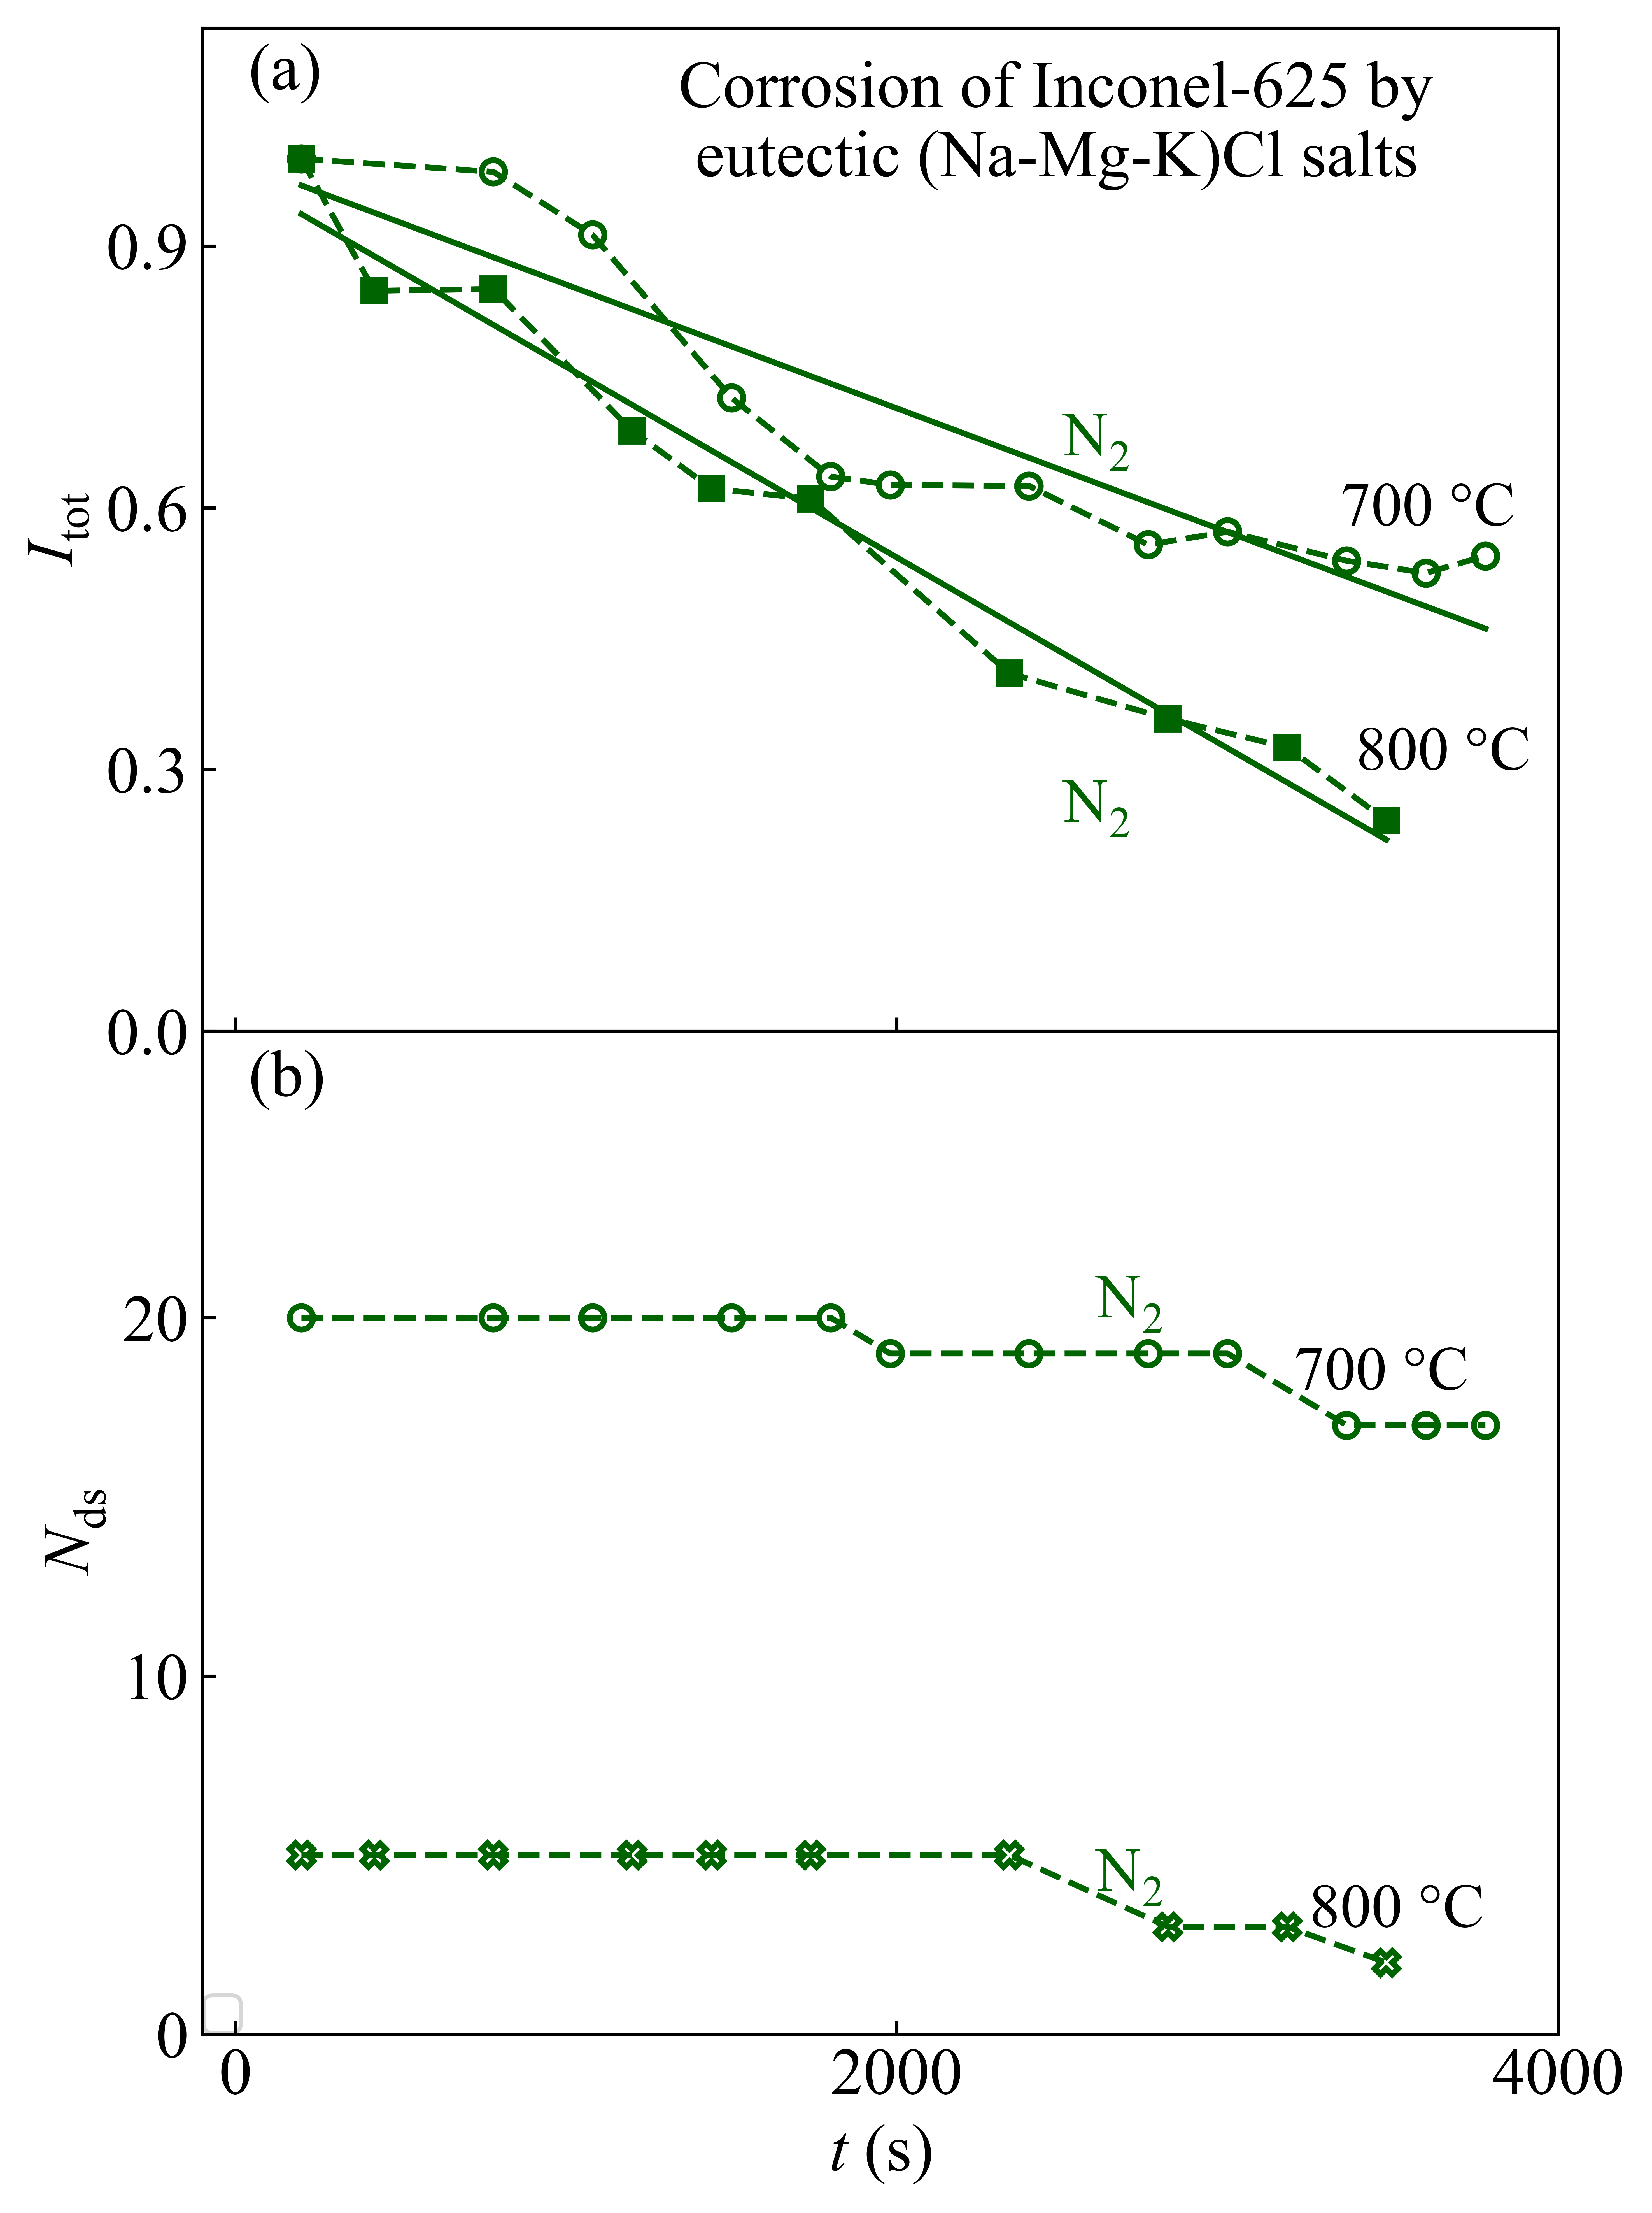

In [6]:
# Sample data set generated from experiments and visualization plots
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib.font_manager import FontProperties
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
from IPython.display import display, Math
th1 = th2 = 0.1
sum_intensity1 =[49394.6+3790+230, 52621.3, 48763.2, 38786.8, 33959.9, 33449.7, 33384.9, 29785.5, 30576.9,
 28261.9+540, 26497.5+1555, 29097.6] #BG corrected
sum_intensity2 = [13198.9, 11202.5, 11229.1, 9084.5, 8210.6, 8054.1, 5415.4, 4726.2, 4294.7, 3188.3]
sum_intensity1 = sum_intensity1/np.max(sum_intensity1)
sum_intensity2 = sum_intensity2/np.max(sum_intensity2)
time1 = np.array([200,780, 1080, 1500, 1800, 1980, 2400, 2760, 3000, 3360, 3600, 3780])#700 N2 Ambient
time2 = np.array([200, 420, 780, 1200, 1440, 1740, 2340, 2820, 3180, 3480])#800 N2 Ambient
ind1 = len(sum_intensity1) - np.searchsorted(sum_intensity1[::-1], th1, side = "right")
ind2 = len(sum_intensity2) - np.searchsorted(sum_intensity2[::-1], th2, side = "right")
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(time1[:ind1+1], list(sum_intensity1[:ind1+1]))
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(time2[:ind2+1], list(sum_intensity2[:ind2+1]))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=1000, figsize=(6, 8), gridspec_kw={'hspace':0,'wspace': 0})
ax1.plot(time1, list(sum_intensity1), 'darkgreen', linestyle='--',marker='o',  markersize = 6, markeredgewidth=1.5, markeredgecolor ='darkgreen', markerfacecolor ='None', label = ' N2 Ambient @ 700 °C')
ax1.plot(time2, list(sum_intensity2), 'darkgreen', linestyle='--',marker='s', label = ' N2 Ambient @ 800 °C')
ax1.plot(time1, intercept1 + slope1*time1, 'darkgreen')
ax1.plot(time2, intercept2 + slope2*time2, 'darkgreen')
x1 = -intercept1/slope1
ax1.set_ylabel(r'$\mathit{I}\mathregular{_{tot}}$', fontsize=17)
ax1.set_ylim([0,1.15])
ax1.tick_params(axis='both', which='major', labelsize=17)
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.text(40,1.08,'(a)', fontsize=17)
plt.xlim([-100, 4000])
ax1.text(2500,0.66,'N$_2$', fontsize=16,color='darkgreen')
ax1.text(3340,0.58,'700 °C', fontsize=16,color='k')
ax1.text(3340,0.3,' 800 °C', fontsize=16, color='k')
plt.legend(loc=(0.0009, 0.0014), fontsize=12).set_zorder(1)
ax1.text(1340,0.98,'Corrosion of Inconel-625 by \n eutectic (Na-Mg-K)Cl salts', fontsize=17,color='black', weight='bold',bbox=dict(facecolor='white',color='white', alpha=1))
plt.xticks(fontsize=12 ), plt.yticks(fontsize=12 )
plt.tight_layout() 
counts_a = [20,20,20,20,20,19,19,19, 19, 17, 17,17]
counts_b = [5,5,5,5,5,5,5,3,3,2]
ax2.plot(time1, counts_a,'darkgreen', linestyle='--', marker='o', markeredgecolor ='darkgreen')
ax2.plot(time2, counts_b,'darkgreen', linestyle='--', marker='X',markeredgecolor ='darkgreen')
ax2.text(2600,20,'N$_2$', fontsize=16,color='darkgreen')
ax2.text(2600,4,'N$_2$', fontsize=16, color='darkgreen')
plt.xlabel(r'$\it{t}$ (s)', fontsize=17)
plt.ylabel(r'$\mathit{N}\mathregular{_{ds}}$', fontsize=17)
ax2.tick_params(axis='both', which='major', labelsize=17)
plt.locator_params(nbins=4, axis='both')
plt.xlim([-100, 4000])
plt.ylim([0, 28])
plt.text(40,26.2,'(b)', fontsize=17, fontweight='bold')
plt.tight_layout() 
ax1.get_shared_x_axes().join(ax1, ax2)
plt.savefig('time_vs_intensity_normalized_sum.pdf') 
plt.show()